Figuring out how to use PAM

In [104]:
import os
from copy import deepcopy

import geopandas as gp
import pandas as pd
from pam import read, write
from pam.core import Population
from pam.plot.stats import plot_activity_times, plot_leg_times
from pam.samplers.basic import freq_sample
from pam.samplers.spatial import RandomPointSampler

from acbm.preprocessing import nts_filter_by_year

In [105]:
path_psu = "../data/external/nts/UKDA-5340-tab/tab/psu_eul_2002-2022.tab"
psu = pd.read_csv(path_psu, sep="\t")

path_individuals = "../data/external/nts/UKDA-5340-tab/tab/individual_eul_2002-2022.tab"
nts_individuals = pd.read_csv(path_individuals,
                              sep="\t",
                              usecols = ['IndividualID',
                                         'HouseholdID',
                                          'PSUID',
                                          'Age_B01ID',
                                          'Age_B04ID',
                                          'Sex_B01ID',
                                          'OfPenAge_B01ID',
                                          'HRPRelation_B01ID',
                                          'EdAttn1_B01ID',
                                          'EdAttn2_B01ID',
                                          'EdAttn3_B01ID',
                                          'OwnCycle_B01ID', # Owns a cycle
                                          'DrivLic_B02ID', # type of driving license
                                          'CarAccess_B01ID',
                                          'IndIncome2002_B02ID',
                                          'IndWkGOR_B02ID', # Region of usual place of work
                                          'EcoStat_B02ID', # Working status of individual
                                          'EcoStat_B03ID',
                                          'NSSec_B03ID', # NSSEC high level breakdown
                                          'SC_B01ID', # Social class of individual
                                          'Stat_B01ID', # employee or self-employed
                                          'WkMode_B01ID', # Usual means of travel to work
                                          'WkHome_B01ID', # Work from home
                                          'PossHom_B01ID', # Is it possible to work from home?
                                          'OftHome_B01ID', # How often work from home
                                          'TravSh_B01ID', # Usual mode from main food shopping trip
                                          'SchDly_B01ID', # Daily school journey?
                                          'SchTrav_B01ID', # Usual mode of travel to school
                                          'SchAcc_B01ID', # IS school trip accompanied by an adult?
                                          'FdShp_B01ID', # How do you usually carry ot main food shop (go to shop, online etc)
                                          ]
)


path_households = "../data/external/nts/UKDA-5340-tab/tab/household_eul_2002-2022.tab"
nts_households = pd.read_csv(path_households,
                             sep="\t",
                             usecols = ['HouseholdID',
                                        'PSUID',
                                        'HHIncome2002_B02ID',
                                        'AddressType_B01ID', # type of house
                                        'Ten1_B02ID', # type of tenure
                                        'HHoldNumAdults', # total no. of adults in household
                                        'HHoldNumChildren', # total no. of children in household
                                        'HHoldNumPeople', # total no. of people in household
                                        'NumLicHolders', # total no. of driving license holders in household
                                        'HHoldEmploy_B01ID', # number of employed in household
                                        'NumBike', # no. of bikes
                                        'NumCar', # no. of cars
                                        'NumVanLorry', # no. of vans or lorries
                                        'NumMCycle', # no. of motorcycles
                                        'WalkBus_B01ID', # walk time from house to nearest bus stop
                                        'Getbus_B01ID', # frequency of bus service
                                        'WalkRail_B01ID', # walk time from house to nearest rail station
                                        'JTimeHosp_B01ID', # journey time to nearest hospital
                                        'DVShop_B01ID', # person no. for main food shooper in hh
                                        'Settlement2011EW_B03ID', # ONS Urban/Rural: 2 categories
                                        'Settlement2011EW_B04ID', # ONS Urban/Rural: 3 categories
                                        'HHoldOAClass2011_B03ID', # Census 2011 OA Classification
                                        'HRPWorkStat_B02ID', # HH ref person working status
                                        'HRPSEGWorkStat_B01ID', #  HH ref person socio economic group for active workers
                                        'W0', # Unweighted interview sample
                                        'W1', # Unweighted diary sample
                                        'W2', # Weighted diary sample
                                        'W3', # Weighted interview sample
                                        ]
  )


path_trips = "../data/external/nts/UKDA-5340-tab/tab/trip_eul_2002-2022.tab"
nts_trips = pd.read_csv(path_trips,
                        sep="\t",
                        usecols = ['TripID',
                                   'DayID',
                                   'IndividualID',
                                   'HouseholdID',
                                   'PSUID',
                                   'PersNo',
                                   'TravDay',
                                   'JourSeq',
                                   'ShortWalkTrip_B01ID',
                                   'NumStages',
                                   #'MainMode_B03ID',
                                   'MainMode_B04ID',
                                   'TripPurpFrom_B01ID',
                                   'TripPurpTo_B01ID',
                                   'TripPurpose_B04ID',
                                   'TripStart',
                                   'TripEnd',
                                   'TripTotalTime',
                                   'TripTravTime',
                                   'TripDisIncSW',
                                   'TripDisExSW',
                                   'TripOrigGOR_B02ID',
                                   'TripDestGOR_B02ID',
                                   #'W5',
                                   #'W5xHH'
                        ]
    )


In [106]:
years = [2022]

nts_individuals = nts_filter_by_year(nts_individuals, psu, years)
nts_households = nts_filter_by_year(nts_households, psu, years)
nts_trips = nts_filter_by_year(nts_trips, psu, years)

In [107]:
nts_trips = nts_trips.rename(
    columns={  # rename data
        "IndividualID": "pid",
        "HouseholdID": "hid",
        "JourSeq": "seq",
        "TripOrigGOR_B02ID": "ozone",
        "TripDestGOR_B02ID": "dzone",
        "TripPurpFrom_B01ID": "oact",
        "TripPurpTo_B01ID": "dact",
        "MainMode_B04ID": "mode",
        "TripStart": "tst",
        "TripEnd": "tet",
    }
)

nts_trips.head(10)

,TripID,DayID,pid,hid,PSUID,PersNo,TravDay,seq,ShortWalkTrip_B01ID,NumStages,...,dact,TripPurpose_B04ID,tst,tet,TripDisIncSW,TripDisExSW,TripTotalTime,TripTravTime,ozone,dzone
5043955,2022000001,2022000001,2022000001,2022000001,2022000002,1,1,1,2,1,...,5,4,610.0,625.0,6.0,6.0,15,15.0,8,8.0
5043956,2022000002,2022000001,2022000001,2022000001,2022000002,1,1,2,2,1,...,23,4,645.0,660.0,6.0,6.0,15,15.0,8,8.0
5043957,2022000003,2022000001,2022000001,2022000001,2022000002,1,1,3,2,1,...,11,7,855.0,860.0,2.0,2.0,5,5.0,8,8.0
5043958,2022000004,2022000001,2022000001,2022000001,2022000002,1,1,4,2,1,...,23,7,930.0,935.0,2.0,2.0,5,5.0,8,8.0
5043959,2022000005,2022000002,2022000001,2022000001,2022000002,1,2,1,2,1,...,4,4,1110.0,1115.0,1.0,1.0,5,5.0,8,8.0
5043960,2022000006,2022000002,2022000001,2022000001,2022000002,1,2,2,2,1,...,23,4,1140.0,1145.0,1.0,1.0,5,5.0,8,8.0
5043961,2022000007,2022000003,2022000001,2022000001,2022000002,1,3,1,2,1,...,12,7,440.0,445.0,1.5,1.5,5,5.0,8,8.0
5043962,2022000008,2022000003,2022000001,2022000001,2022000002,1,3,2,2,1,...,23,7,520.0,525.0,1.5,1.5,5,5.0,8,8.0
5043963,2022000009,2022000005,2022000001,2022000001,2022000002,1,5,1,2,1,...,5,4,610.0,630.0,6.5,6.5,20,20.0,8,8.0
5043964,2022000010,2022000005,2022000001,2022000001,2022000002,1,5,2,2,1,...,23,4,705.0,725.0,6.5,6.5,20,20.0,8,8.0


In [108]:
# get data types of each column
nts_trips.dtypes


TripID                   int64
DayID                    int64
pid                      int64
hid                      int64
PSUID                    int64
PersNo                   int64
TravDay                  int64
seq                      int64
ShortWalkTrip_B01ID      int64
NumStages                int64
mode                     int64
oact                     int64
dact                     int64
TripPurpose_B04ID        int64
tst                    float64
tet                    float64
TripDisIncSW           float64
TripDisExSW            float64
TripTotalTime            int64
TripTravTime           float64
ozone                    int64
dzone                  float64
dtype: object

In [109]:
nts_individuals = nts_individuals.rename(
    columns={  # rename data
        "IndividualID": "pid",
        "HouseholdID": "hid",
    }
)

nts_individuals


,pid,hid,PSUID,Age_B01ID,Age_B04ID,Sex_B01ID,OfPenAge_B01ID,HRPRelation_B01ID,EdAttn1_B01ID,EdAttn2_B01ID,...,Stat_B01ID,WkMode_B01ID,WkHome_B01ID,PossHom_B01ID,OftHome_B01ID,TravSh_B01ID,SchDly_B01ID,SchTrav_B01ID,SchAcc_B01ID,FdShp_B01ID
374575,2022000389,2022000172,2022000030,17,9,2,1,1,1,-9,...,1,-9,-10,-10,-9,-10,-9,-9,-9,-10
374576,2022000390,2022000173,2022000030,14,7,1,2,99,1,-9,...,1,4,-10,-10,7,-10,-9,-9,-9,-10
374577,2022000001,2022000001,2022000002,15,8,2,2,99,1,-9,...,1,-9,-10,-10,-9,-10,-9,-9,-9,-10
374578,2022000002,2022000001,2022000002,15,8,1,2,1,1,-9,...,2,-9,-10,-10,-9,-10,-9,-9,-9,-10
374579,2022000003,2022000002,2022000002,21,9,2,1,99,1,-9,...,1,-9,-10,-10,-9,-10,-9,-9,-9,-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384212,2022008251,2022003646,2022000626,5,3,2,2,3,-9,-9,...,-9,-9,-10,-10,-9,-10,2,-9,-9,-10
384213,2022008252,2022003646,2022000626,4,2,1,2,3,-9,-9,...,-9,-9,-10,-10,-9,-10,1,9,2,-10
384214,2022008253,2022003647,2022000626,18,9,1,1,99,2,2,...,1,-9,-10,-10,-9,-10,-9,-9,-9,-10
384215,2022008254,2022003648,2022000627,14,7,1,2,99,1,-9,...,1,-9,-10,-10,-9,-10,-9,-9,-9,-10


In [110]:
mode_mapping = {
    1: "walk",
    2: "bike",
    3: "car",  #'Car/van driver'
    4: "car",  #'Car/van driver'
    5: "motorcycle",  #'Motorcycle',
    6: "car",  #'Other private transport',
    7: "pt",  # Bus in London',
    8: "pt",  #'Other local bus',
    9: "pt",  #'Non-local bus',
    10: "pt",  #'London Underground',
    11: "pt",  #'Surface Rail',
    12: "car",  #'Taxi/minicab',
    13: "pt",  #'Other public transport',
    -10: "DEAD",
    -8: "NA",
}

purp_mapping = {
    1: "work",
    2: "work",  #'In course of work',
    3: "education",
    4: "shop",  #'Food shopping',
    5: "shop",  #'Non food shopping',
    6: "medical",  #'Personal business medical',
    7: "other",  #'Personal business eat/drink',
    8: "other",  #'Personal business other',
    9: "other",  #'Eat/drink with friends',
    10: "visit",  #'Visit friends',
    11: "other",  #'Other social',
    12: "other",  #'Entertain/ public activity',
    13: "other",  #'Sport: participate',
    14: "home",  #'Holiday: base',
    15: "other",  #'Day trip/just walk',
    16: "other",  #'Other non-escort',
    17: "escort",  #'Escort home',
    18: "escort",  #'Escort work',
    19: "escort",  #'Escort in course of work',
    20: "escort",  #'Escort education',
    21: "escort",  #'Escort shopping/personal business',
    22: "escort",  #'Other escort',
    23: "home",  #'Home',
    -10: "DEAD",
    -8: "NA",
}


nts_trips["mode"] = nts_trips["mode"].map(mode_mapping)

nts_trips["oact"] = nts_trips["oact"].map(purp_mapping)

nts_trips["dact"] = nts_trips["dact"].map(purp_mapping)

nts_trips

,TripID,DayID,pid,hid,PSUID,PersNo,TravDay,seq,ShortWalkTrip_B01ID,NumStages,...,dact,TripPurpose_B04ID,tst,tet,TripDisIncSW,TripDisExSW,TripTotalTime,TripTravTime,ozone,dzone
5043955,2022000001,2022000001,2022000001,2022000001,2022000002,1,1,1,2,1,...,shop,4,610.0,625.0,6.0,6.0,15,15.0,8,8.0
5043956,2022000002,2022000001,2022000001,2022000001,2022000002,1,1,2,2,1,...,home,4,645.0,660.0,6.0,6.0,15,15.0,8,8.0
5043957,2022000003,2022000001,2022000001,2022000001,2022000002,1,1,3,2,1,...,other,7,855.0,860.0,2.0,2.0,5,5.0,8,8.0
5043958,2022000004,2022000001,2022000001,2022000001,2022000002,1,1,4,2,1,...,home,7,930.0,935.0,2.0,2.0,5,5.0,8,8.0
5043959,2022000005,2022000002,2022000001,2022000001,2022000002,1,2,1,2,1,...,shop,4,1110.0,1115.0,1.0,1.0,5,5.0,8,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5150103,2022111203,2022059534,2022009864,2022004368,2022000756,1,6,2,2,1,...,home,1,965.0,982.0,6.0,6.0,17,17.0,9,9.0
5150104,2022111204,2022059535,2022009864,2022004368,2022000756,1,7,1,2,1,...,escort,5,800.0,804.0,0.5,0.5,4,4.0,9,9.0
5150105,2022111205,2022059535,2022009864,2022004368,2022000756,1,7,2,2,1,...,escort,5,810.0,828.0,3.0,3.0,18,18.0,9,9.0
5150106,2022111206,2022059535,2022009864,2022004368,2022000756,1,7,3,2,1,...,visit,7,960.0,985.0,3.0,3.0,25,25.0,9,9.0


In [ ]:
# remove "freq" column from nts_trips
nts_trips = nts_trips.drop(columns=["freq"])

In [113]:
def remove_broken_plans(plan):
    if plan.isnull().values.any():
        return None
    for col in ['ozone', 'dzone']:
        if -8 in list(plan[col]):
            return None
    # Hussein logic to fix population() error. Remove plans that don't start from home
    if plan.loc[plan['seq'] == 1, 'oact'].values[0] != "home":
        return None
    return plan

nts_trips2 = (
    nts_trips.groupby(["pid", "TravDay"], group_keys=False)
    .apply(remove_broken_plans)
    .reset_index(drop=True)
)

nts_trips2

/tmp/ipykernel_843062/3199233427.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(remove_broken_plans)


,TripID,DayID,pid,hid,PSUID,PersNo,TravDay,seq,ShortWalkTrip_B01ID,NumStages,...,dact,TripPurpose_B04ID,tst,tet,TripDisIncSW,TripDisExSW,TripTotalTime,TripTravTime,ozone,dzone
0,2022000001,2022000001,2022000001,2022000001,2022000002,1,1,1,2,1,...,shop,4,610.0,625.0,6.0,6.0,15,15.0,8,8.0
1,2022000002,2022000001,2022000001,2022000001,2022000002,1,1,2,2,1,...,home,4,645.0,660.0,6.0,6.0,15,15.0,8,8.0
2,2022000003,2022000001,2022000001,2022000001,2022000002,1,1,3,2,1,...,other,7,855.0,860.0,2.0,2.0,5,5.0,8,8.0
3,2022000004,2022000001,2022000001,2022000001,2022000002,1,1,4,2,1,...,home,7,930.0,935.0,2.0,2.0,5,5.0,8,8.0
4,2022000005,2022000002,2022000001,2022000001,2022000002,1,2,1,2,1,...,shop,4,1110.0,1115.0,1.0,1.0,5,5.0,8,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99331,2022111203,2022059534,2022009864,2022004368,2022000756,1,6,2,2,1,...,home,1,965.0,982.0,6.0,6.0,17,17.0,9,9.0
99332,2022111204,2022059535,2022009864,2022004368,2022000756,1,7,1,2,1,...,escort,5,800.0,804.0,0.5,0.5,4,4.0,9,9.0
99333,2022111205,2022059535,2022009864,2022004368,2022000756,1,7,2,2,1,...,escort,5,810.0,828.0,3.0,3.0,18,18.0,9,9.0
99334,2022111206,2022059535,2022009864,2022004368,2022000756,1,7,3,2,1,...,visit,7,960.0,985.0,3.0,3.0,25,25.0,9,9.0


In [147]:
# keep a specific day only
nts_trips2 = nts_trips2[nts_trips2["TravDay"] == 3]

In [114]:
# convert tst and tet to int
nts_trips2["tst"] = nts_trips2["tst"].astype(int)
nts_trips2["tet"] = nts_trips2["tet"].astype(int)

In [115]:
nts_households = nts_households.rename(
    columns={  # rename data
        "HouseholdID": "hid",
    }
)

nts_households

,hid,PSUID,HHIncome2002_B02ID,AddressType_B01ID,Ten1_B02ID,HHoldNumAdults,HHoldNumChildren,HHoldNumPeople,NumLicHolders,HRPWorkStat_B02ID,...,WalkRail_B01ID,JTimeHosp_B01ID,DVShop_B01ID,Settlement2011EW_B03ID,Settlement2011EW_B04ID,HHoldOAClass2011_B03ID,W0,W1,W2,W3
157589,2022001043,2022000204,2.0,-9,1,1,1,2,1.0,1,...,-10,-10,-10,1,1,-10,1,1,0.631151,0.766361
157590,2022001044,2022000204,2.0,-9,2,2,2,4,1.0,4,...,-10,-10,-10,1,1,-10,1,1,0.936950,0.924594
157591,2022001045,2022000204,2.0,-9,1,5,0,5,3.0,1,...,-10,-10,-10,1,1,-10,1,1,1.038188,1.024334
157592,2022001046,2022000204,2.0,-9,2,2,0,2,0.0,3,...,-10,-10,-10,1,1,-10,1,1,0.731186,0.777300
157593,2022001047,2022000204,2.0,-9,1,2,0,2,2.0,1,...,-10,-10,-10,1,1,-10,1,1,0.610826,0.687786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161879,2022004365,2022000756,3.0,-9,1,2,0,2,2.0,1,...,-10,-10,-10,1,2,-10,1,1,0.763437,0.806818
161880,2022004366,2022000756,3.0,-9,3,3,1,4,3.0,3,...,-10,-10,-10,1,2,-10,1,1,0.737873,0.744252
161881,2022004367,2022000756,2.0,-9,2,2,1,3,2.0,1,...,-10,-10,-10,1,2,-10,1,0,0.000000,0.982853
161882,2022004368,2022000756,2.0,-9,1,1,0,1,1.0,1,...,-10,-10,-10,1,2,-10,1,1,1.158187,1.198722


In [149]:
# keep only nts households where the household is in the trips data
nts_households2 = nts_households[nts_households["hid"].isin(nts_trips2["hid"])]
# same with individuals
nts_individuals2 = nts_individuals[nts_individuals["pid"].isin(nts_trips2["pid"])]

In [150]:
population = read.load_travel_diary(
    trips=nts_trips2, persons_attributes=nts_individuals2, hhs_attributes=nts_households2
)

population

/home/hussein/miniconda3/envs/pam/lib/python3.11/site-packages/pam/read/diary.py:280: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  persons_attributes["freq"] = None
/home/hussein/miniconda3/envs/pam/lib/python3.11/site-packages/pam/read/diary.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hhs_attributes["freq"] = None


In [151]:
population.households


{2022000001: <pam.core.Household at 0x7eb63185ce90>,
 2022000002: <pam.core.Household at 0x7eb631b91990>,
 2022000003: <pam.core.Household at 0x7eb631c6f690>,
 2022000004: <pam.core.Household at 0x7eb631c6c5d0>,
 2022000005: <pam.core.Household at 0x7eb631c6fed0>,
 2022000006: <pam.core.Household at 0x7eb631c6dfd0>,
 2022000008: <pam.core.Household at 0x7eb631c6fd50>,
 2022000010: <pam.core.Household at 0x7eb631b92c10>,
 2022000011: <pam.core.Household at 0x7eb631b90610>,
 2022000012: <pam.core.Household at 0x7eb631bce890>,
 2022000014: <pam.core.Household at 0x7eb631b91690>,
 2022000016: <pam.core.Household at 0x7eb631b92490>,
 2022000018: <pam.core.Household at 0x7eb631bcd750>,
 2022000019: <pam.core.Household at 0x7eb631bcc110>,
 2022000020: <pam.core.Household at 0x7eb631bcf610>,
 2022000022: <pam.core.Household at 0x7eb631bcc610>,
 2022000024: <pam.core.Household at 0x7eb631bcc750>,
 2022000025: <pam.core.Household at 0x7eb631bcdcd0>,
 2022000028: <pam.core.Household at 0x7eb631bc

Household: 2022001554
{'PSUID': 2022000281, 'HHIncome2002_B02ID': 1.0, 'AddressType_B01ID': -9, 'Ten1_B02ID': 1, 'HHoldNumAdults': 2, 'HHoldNumChildren': 2, 'HHoldNumPeople': 4, 'NumLicHolders': 2.0, 'HRPWorkStat_B02ID': 1, 'HRPSEGWorkStat_B01ID': -10, 'HHoldEmploy_B01ID': 5, 'NumBike': 4, 'NumCar': 2.0, 'NumMCycle': 0.0, 'NumVanLorry': 0.0, 'WalkBus_B01ID': -10, 'Getbus_B01ID': -10, 'WalkRail_B01ID': -10, 'JTimeHosp_B01ID': -10, 'DVShop_B01ID': -10, 'Settlement2011EW_B03ID': 1, 'Settlement2011EW_B04ID': 2, 'HHoldOAClass2011_B03ID': -10, 'W0': 1, 'W1': 1, 'W2': 1.9924061150795, 'W3': 1.58735774545292}
Person: 2022003508
{'PSUID': 2022000281, 'Age_B01ID': 14, 'Age_B04ID': 7, 'Sex_B01ID': 1, 'OfPenAge_B01ID': 2, 'HRPRelation_B01ID': 99, 'EdAttn1_B01ID': 1, 'EdAttn2_B01ID': -9, 'EdAttn3_B01ID': -9, 'OwnCycle_B01ID': -10, 'DrivLic_B02ID': 1, 'CarAccess_B01ID': 2, 'IndIncome2002_B02ID': 2, 'IndWkGOR_B02ID': 5.0, 'EcoStat_B02ID': 1, 'EcoStat_B03ID': 1, 'NSSec_B03ID': 3, 'SC_B01ID': -10, 'Sta

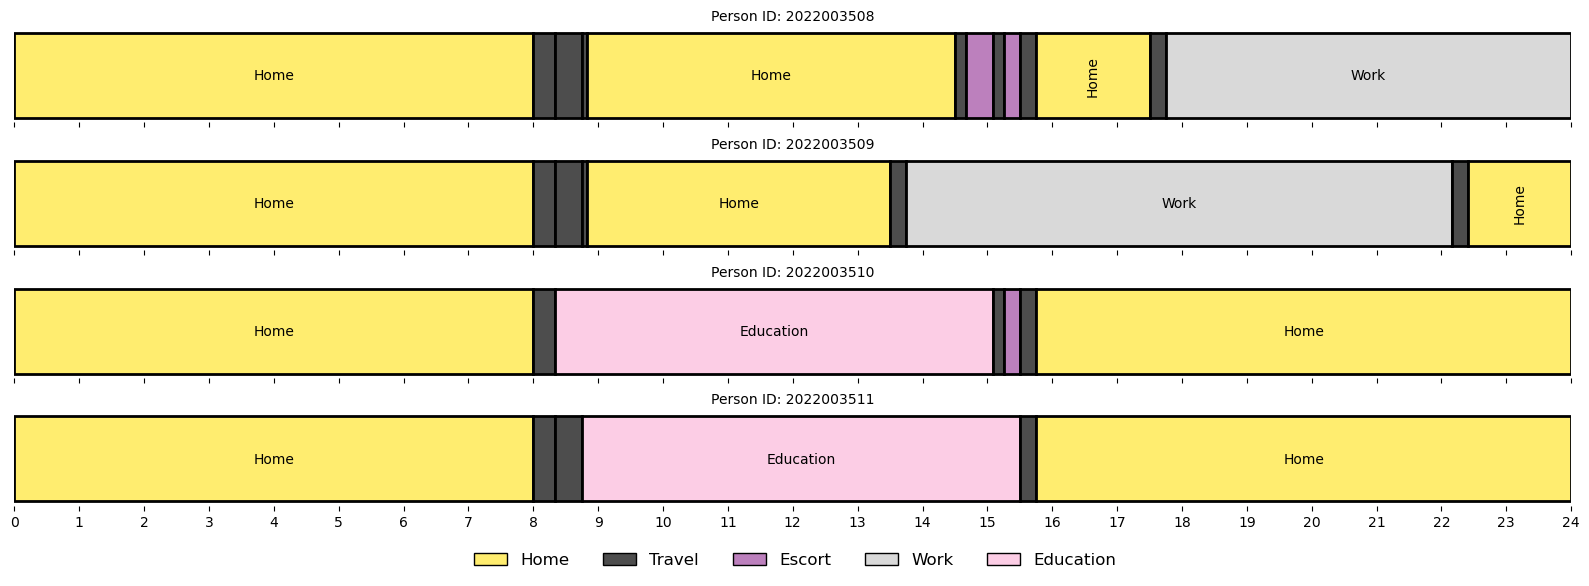

In [170]:
# I want to see what's inside ppoulation
#household_i = population.households[2022001569]
household_i = population.households[2022001554]

household_i.print()
household_i.plot()